In [1]:
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from sklearn.metrics import r2_score, mean_squared_error
from tool_kit import calc_ccc, accuracy_plot

import pandas as pd
import numpy as np
import warnings
import joblib
warnings.filterwarnings('ignore')

folder = '/mnt/inca/soc_eu_model'
df = pd.read_csv(f'{folder}/data/004.0_validate.pnts_soc.csv',low_memory=False)

# covariates
with open(f'{folder}/SOC-EU/features/002_selected.covar_rank.freq.txt', 'r') as file:
    lines = file.readlines()
covs = [line.strip() for line in lines]

# target
dff = df.loc[df['oc'].notna()]
dff = dff.loc[dff['oc']>5]
dff = dff.loc[dff['ref']!='nl.bis'] # data from nl.bis show weird patterns
# dff.loc[:,'oc_log1p'] = np.log1p(dff['oc'])
# tgt = 'oc_log1p'

spatial_cv_column = 'tile_id'
test = dff
test = test.dropna(subset=covs,how='any')
tgt = 'oc_log1p'
test.loc[:,'oc_log1p'] = np.log1p(test['oc'])

/home/opengeohub/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### evaluate all the base models

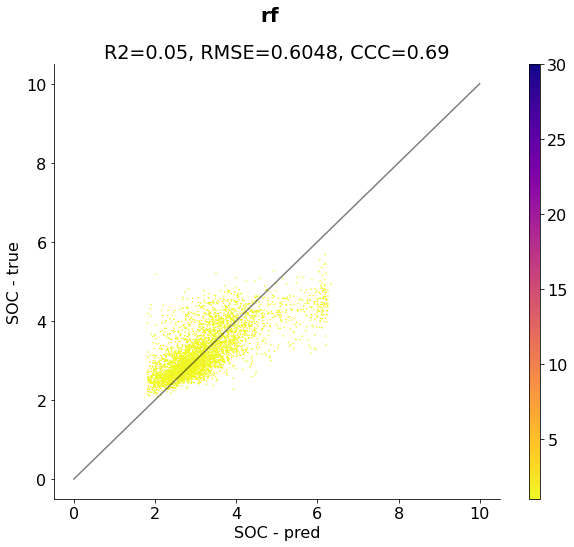

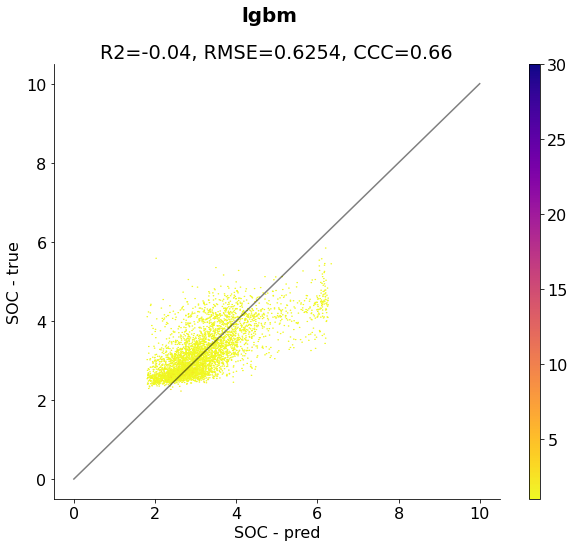

AttributeError: Can't get attribute 'RegressionModel' on <module '__main__'>

In [3]:
# get all the trained models
model_list = find_files(f'{folder}/SOC-EU/model/','*model*')
model_list = [str(i) for i in model_list]

results = []
for model_path in model_list:
    model_name = model_path.split('_')[-1].split('.')[0]
    model = joblib.load(model_path)
    
    y_pred_log1p = model.predict(test[covs])
    y_pred = y_pred_log1p
#     y_pred = np.expm1(y_pred_log1p)
    accuracy_plot(y_pred, test[tgt], title_text=model_name, show_range=[0,10])
    
    # Calculate metrics
    ccc = calc_ccc(test[tgt], y_pred)
    rmse = np.sqrt(mean_squared_error(test[tgt], y_pred))
    r2 = r2_score(test[tgt], y_pred)
    
    # Store results
    results.append({
        'Model Name': model_name,
        'CCC': ccc,
        'RMSE': rmse,
        'R2': r2
    })
    
results_df = pd.DataFrame(results)
results_df.to_csv(f'{folder}/SOC-EU/model/012_model.performance_base.model.compare',index=False)
results_df

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Convert DataFrame to PyTorch tensors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train[covs])

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(train[[tgt]]).reshape(-1)

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32).reshape(-1, 1)
groups = train[spatial_cv_column].values

# Define PyTorch model class
class RegressionModel(nn.Module):
    def __init__(self, units, layers, dropout_rate):
        super().__init__()
        layers_list = [nn.Linear(X.shape[1], units), nn.ReLU(), nn.Dropout(dropout_rate)]
        for _ in range(1, layers):
            layers_list += [nn.Linear(units, units), nn.ReLU(), nn.Dropout(dropout_rate)]
        layers_list.append(nn.Linear(units, 1))
        self.net = nn.Sequential(*layers_list)
    
    def forward(self, x):
        return self.net(x)

# Skorch wrapper
def skorch_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    return NeuralNetRegressor(
        RegressionModel,
        module__units=units,
        module__layers=layers,
        module__dropout_rate=dropout_rate,
        max_epochs=10,  # This value will be overwritten by GridSearchCV
        lr=learning_rate,
        optimizer=optim.Adam,
        criterion=nn.MSELoss,
        batch_size=64,  # This value will be overwritten by GridSearchCV
        verbose=0
    )

param_grid = {
    'module__units': [64, 128, 256],
    'module__layers': [2,4,6],
    'module__dropout_rate': [0.2, 0.3, 0.4],
    'lr': [0.0005, 0.001, 0.01, 0.02],
    'max_epochs': [10, 20],
    'batch_size': [64, 128]
}

ttprint('start grid search')
cv = GroupKFold(n_splits=3)
grid = GridSearchCV(estimator=skorch_model(), param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid.fit(X, y, groups=groups)
ttprint('finish tuning')

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_ann = grid_result.best_estimator_
joblib.dump(best_ann, '/mnt/inca/soc_eu_model/data/009.1_model_ann.joblib')

# check accuracy
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(test[covs])
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = test[tgt].values

y_pred_ann = best_ann.predict(X_test_scaled)
y_pred_ann = target_scaler.inverse_transform(y_pred_ann).flatten()
accuracy_plot(y_test, y_pred_ann, title_text='ANN')

In [ ]:
# check accuracy
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(test[covs])
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = test[tgt].values

y_pred_ann = best_ann.predict(X_test_scaled)
y_pred_ann = target_scaler.inverse_transform(y_pred_ann).flatten()
accuracy_plot(y_test, y_pred_ann, title_text='ANN')

In [ ]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        diff = y_true - y_pred
        loss = torch.max(self.quantile * diff, (self.quantile - 1) * diff)
        return torch.mean(loss)
    
best_params = grid_result.best_params_

def create_quantile_nn(quantile):
    return NeuralNetRegressor(
        RegressionModel, 
        module__units=best_params['module__units'],
        module__layers=best_params['module__layers'],
        module__dropout_rate=best_params['module__dropout_rate'],
        max_epochs=best_params['max_epochs'],
        lr=best_params['lr'],
        optimizer=optim.Adam,
        criterion=QuantileLoss(quantile),
        batch_size=best_params['batch_size'],
        verbose=0
    )


q05_model = create_quantile_nn(0.05)
q05_model.fit(X, y)
joblib.dump(q05_model, '/mnt/inca/soc_eu_model/data/009.2_model_ann.p05.joblib')

q95_model = create_quantile_nn(0.95)
q95_model.fit(X, y)
joblib.dump(q95_model, '/mnt/inca/soc_eu_model/data/009.3_model_ann.p95.joblib')

### Cubist

In [ ]:
from cubist import Cubist
param_cubist = {
    'n_rules': [100, 300, 500],
    'n_committees': [1, 5, 10],
    'neighbors': [None, 5, 9],
    'unbiased': [False, True],
    'auto': [True, False],
    'extrapolation': [0.02, 0.05],
    'sample': [None, 0.1, 0.5],
    'cv': [10]
}

tune_cubist = HalvingGridSearchCV(
    estimator=Cubist(),
    param_grid=param_cubist,
    scoring='neg_mean_squared_error',
    n_jobs=90,
    cv=3
)

# Start fine-tuning process
ttprint('start fine tuning cubist')
tune_cubist.fit(train_set[covs], train_set[tgt])
ttprint('finish fitting')

cubist = tune_cubist.best_estimator_
dump(cubist, '/mnt/inca/soc_eu_model/data/011_model_cubist.joblib')

print("Best parameters:", tune_cubist.best_params_)
dump(tune_cubist.best_params_, '/mnt/inca/soc_eu_model/data/012_param_cubist.joblib')

y_pred_cubist = cubist.predict(test_set[covs])

### lrb

In [ ]:
ttprint(f'fit linear regression Boost regressor')
from lrboost import LRBoostRegressor
lrb = LRBoostRegressor().fit(train_set[covs], train_set[tgt])
y_pred_lrb = lrb.predict(test_set[covs], detail=True)
ttprint(f'finish fitting linear regression Boost regressor')

dump(lrb, '/mnt/inca/soc_eu_model/data/011_model_lrb.joblib')

### evaluation

In [ ]:
y_test_ori = test['oc']
# y_pred_rf = np.expm1(y_pred_rf)
# y_pred_lgbm = np.expm1(y_pred_lgbm)
y_pred_ann = np.expm1(y_pred_ann)


# accuracy_plot(test_set[tgt], y_pred_rf, title_text='RF')
# accuracy_plot(test_set[tgt], y_pred_lrb['final_prediction'], title_text='LRB')
# accuracy_plot(test_set[tgt], y_pred_cubist, title_text='Cubist')
accuracy_plot(y_test_ori, y_pred_ann, title_text='ANN original OC')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

def calc_ccc(y_true, y_pred):
    pearson_corr = pearsonr(y_true, y_pred)[0]
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    ccc = (2 * pearson_corr * np.sqrt(var_true) * np.sqrt(var_pred)) / (var_true + var_pred + (mean_true - mean_pred)**2)
    return ccc
    
def accuracy_plot(y_test, y_pred, title_text):

    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ccc = calc_ccc(y_test, y_pred)

    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize = (8,8))
    fig.suptitle(title_text, fontsize=20, fontweight='bold')
    plt.title(f'R2={r2:.2f}, rmse={rmse:.4f}, ccc={ccc:.2f}')
    plt.hexbin(y_test, y_pred, gridsize=(300, 300) , cmap = 'plasma_r', mincnt=1, vmax = 200)#, xscale =25, yscale = 25)
    
    plt.xlabel('SOC - test'), plt.ylabel('SOC - pred')

    # square plot
    ax = plt.gca()
    ax.set_aspect('auto', adjustable='box')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #diagonal 
    ax.plot([-10, 300], [-10, 300], "-k", alpha = .5)
    ax.set_xlim(-5,200)
    ax.set_ylim(-5,200)
    
    # Create new axes according to image position
    cax = fig.add_axes([ax.get_position().x1+0.05,
                        ax.get_position().y0,
                        0.02,
                        ax.get_position().height])

    # Plot vertical colorbar
    cb = plt.colorbar(cax=cax)
    #cb.outline.set_visible(False)
    #cb.set_ticks([1,100,200,300])

    plt.show()
    
accuracy_plot(test_set[tgt], y_pred_rf, title_text='RF')
accuracy_plot(test_set[tgt], y_pred_lrb['final_prediction'], title_text='LRB')
# accuracy_plot(test_set[tgt], y_pred_cubist, title_text='Cubist')
accuracy_plot(test_set[tgt], y_pred_ann, title_text='MLP (NN)')

### ensemble

In [ ]:
cubist
ann
rf